# GBDT on DonorsChoose

## Loading Data

In [ ]:
import pandas
import numpy as np
import scipy
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pickle
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data = pandas.read_csv('/content/preprocessed_data/preprocessed_data.csv', nrows = 35000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
sid = SentimentIntensityAnalyzer()

for essay in tqdm(data['essay']):
    ss_1 = sid.polarity_scores(essay)
    data['positive'] = ss_1['pos']
    data['negative'] = ss_1['neg']
    data['neutral'] = ss_1['neu']
    data['compound'] = ss_1['compound']
    

100%|██████████| 35000/35000 [01:49<00:00, 318.69it/s]


<h2>Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, data['project_is_approved'], test_size=0.3, stratify = data['project_is_approved'])
X_train.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,positive,negative,neutral,compound
17563,mo,ms,grades_3_5,0,1,music_arts,music,the students school face many challenges class...,269.95,0.292,0.058,0.65,0.9808
13340,wa,mr,grades_6_8,0,1,specialneeds,specialneeds,students receive special education services de...,593.81,0.292,0.058,0.65,0.9808
17144,pa,ms,grades_prek_2,0,1,appliedlearning,other,my students live rural woods adams county penn...,8.99,0.292,0.058,0.65,0.9808
1608,ok,mrs,grades_3_5,76,1,math_science,mathematics,my fourth grade teacher told must lifelong lea...,389.82,0.292,0.058,0.65,0.9808
33283,tn,mrs,grades_3_5,13,1,health_sports,health_wellness,my students active learn best moving they get ...,69.95,0.292,0.058,0.65,0.9808


<h2>Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
# encoding using TF-IDF
tfidfvectorizer = TfidfVectorizer(min_df = 20)
tfidfvectorizer.fit(X_train['essay'].values)

tfidf_train_essay = tfidfvectorizer.transform(X_train['essay'].values)
tfidf_test_essay = tfidfvectorizer.transform(X_test['essay'].values)

essay_tfidf_features = tfidfvectorizer.get_feature_names_out()

print('After TF-IDF, train essay')
print(tfidf_train_essay.shape)

print('After vectorization, test essay')
print(tfidf_test_essay.shape)


After TF-IDF, train essay
(24500, 6677)
After vectorization, test essay
(10500, 6677)


In [ ]:
with open('/content/glove_vectors/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# encoding using TF-IDF W2V

tfidf = TfidfVectorizer()
tfidf.fit(X_train['essay'])
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())

tfidf_w2v_train_essay = []

for sentence in tqdm(X_train['essay']):
    vector = np.zeros(300)
    tfidf_weight = 0
    
    for word in sentence.split():
        if word in glove_words and word in tfidf_words:
            vec = model[word]
            tfidf_val = dictionary[word]*(sentence.count(word)/len(sentence.split())) # get TF-IDF value for word.
            vector += (vec * tfidf_val)
            tfidf_weight += tfidf_val
    
    if tfidf_weight != 0:
        vec /= tfidf_weight
    
    tfidf_w2v_train_essay.append(vector)

print('After TF-IDF W2V, train essay')
print(len(tfidf_w2v_train_essay))
print(len(tfidf_w2v_train_essay[0]))

tfidf_w2v_test_essay = []

for sentence in tqdm(X_test['essay']):
    vector = np.zeros(300)
    tfidf_weight = 0
    
    for word in sentence.split():
        if word in glove_words and word in tfidf_words:
            vec = model[word]
            tfidf_val = dictionary[word]*(sentence.count(word)/len(sentence.split())) # get TF-IDF value for word.
            vector += (vec * tfidf_val)
            tfidf_weight += tfidf_val
    
    if tfidf_weight != 0:
        vec /= tfidf_weight
    
    tfidf_w2v_test_essay.append(vector)

print('After TF-IDF W2V, test essay')
print(len(tfidf_w2v_test_essay))
print(len(tfidf_w2v_test_essay[0]))

100%|██████████| 24500/24500 [00:59<00:00, 414.89it/s]


After TF-IDF W2V, train essay
24500
300


100%|██████████| 10500/10500 [00:24<00:00, 432.41it/s]

After TF-IDF W2V, test essay
10500
300


<h2>Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
# numerical features
train_price = X_train['price'].values.reshape(-1, 1)
test_price = X_test['price'].values.reshape(-1, 1)

train_prev_projects = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
test_prev_projects = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

train_pos_score = X_train['positive'].values.reshape(-1, 1)
print(train_pos_score.shape)
train_neg_score = X_train['negative'].values.reshape(-1, 1)
train_neu_score = X_train['neutral'].values.reshape(-1, 1)
train_com_score = X_train['compound'].values.reshape(-1, 1)

test_pos_score = X_test['positive'].values.reshape(-1, 1)
print(test_pos_score.shape)
test_neg_score = X_test['negative'].values.reshape(-1, 1)
test_neu_score = X_test['neutral'].values.reshape(-1, 1)
test_com_score = X_test['compound'].values.reshape(-1, 1)


(24500, 1)
(10500, 1)


In [ ]:
# categorical features
# https://stackoverflow.com/questions/66122577/response-coding-for-categorical-data
def getResponsetable(data, feature):
    unique_values = data[feature].unique()
    response_table_neg, response_table_pos = dict(), dict()
    
    for value in unique_values:
        total = len(data.loc[(data[feature] == value)])
        pos_count = len(data.loc[(data[feature] == value) & (data['project_is_approved'] == 1)])
        neg_count = len(data.loc[(data[feature] == value) & (data['project_is_approved'] == 0)])
        response_table_neg[value] = neg_count / (pos_count + neg_count)
        response_table_pos[value] = pos_count / (pos_count + neg_count)
        

    return response_table_neg, response_table_pos

In [ ]:
# teacher_prefix, school_state, project_grade_category, clean_categories, clean_subcategories

def createResponseCodedfeatures(data):
    prefix_values_neg, prefix_values_pos = getResponsetable(data, 'teacher_prefix')
    state_values_neg, state_values_pos = getResponsetable(data, 'school_state')
    grade_values_neg, grade_values_pos = getResponsetable(data, 'project_grade_category')
    category_values_neg, category_values_pos = getResponsetable(data, 'clean_categories')
    subcategory_values_neg, subcategory_values_pos = getResponsetable(data, 'clean_subcategories')
    
    df = pandas.DataFrame()
    
    df['teacher_prefix_res_pos'] = data['teacher_prefix'].map(prefix_values_pos)
    df['teacher_prefix_res_neg'] = data['teacher_prefix'].map(prefix_values_neg)
    
    df['school_state_res_pos'] = data['school_state'].map(state_values_pos)
    df['school_state_res_neg'] = data['school_state'].map(state_values_neg)
    
    df['grade_category_res_pos'] = data['project_grade_category'].map(grade_values_pos)
    df['grade_category_res_neg'] = data['project_grade_category'].map(grade_values_neg)
    
    df['clean_categories_res_pos'] = data['clean_categories'].map(category_values_pos)
    df['clean_categories_res_neg'] = data['clean_categories'].map(category_values_neg)
    
    df['clean_subcategories_res_pos'] = data['clean_subcategories'].map(subcategory_values_pos)
    df['clean_subcategories_res_neg'] = data['clean_subcategories'].map(subcategory_values_neg)
    
    return df

In [ ]:
# response code categorical features

train_response_coded = createResponseCodedfeatures(X_train)
test_response_coded = createResponseCodedfeatures(X_test)

X = X_train.join(train_response_coded)

Combine features

In [ ]:
X_train_1 = hstack((tfidf_train_essay, train_price, train_prev_projects, train_pos_score, train_neg_score, train_neu_score, train_com_score, train_response_coded))
X_test_1 = hstack((tfidf_test_essay, test_price, test_prev_projects, test_pos_score, test_neg_score, test_neu_score, test_com_score, test_response_coded))


In [ ]:
tfidf_w2v_train_essay = scipy.sparse.csr_matrix(tfidf_w2v_train_essay)
tfidf_w2v_test_essay = scipy.sparse.csr_matrix(tfidf_w2v_test_essay)
X_train_2 = hstack((tfidf_w2v_train_essay, train_price, train_prev_projects, train_pos_score, train_neg_score, train_neu_score, train_com_score))
X_test_2 = hstack((tfidf_w2v_test_essay, test_price, test_prev_projects, test_pos_score, test_neg_score, test_neu_score, test_com_score))

<h2>Applying Models on different kind of featurization</h2>

XGBoost for response coded categorical features, numerical features and TF-IDF essays

In [ ]:
xgb = XGBClassifier(class_weight = 'balanced', n_jobs = -1)
params = {'n_estimators':[10, 50, 100, 150, 200], 'max_depth': [2, 3, 4, 5, 6]}

clf = GridSearchCV(xgb, params, cv = 3, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf.fit(X_train_1, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(class_weight='balanced', n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             return_train_score=True, scoring='roc_auc')

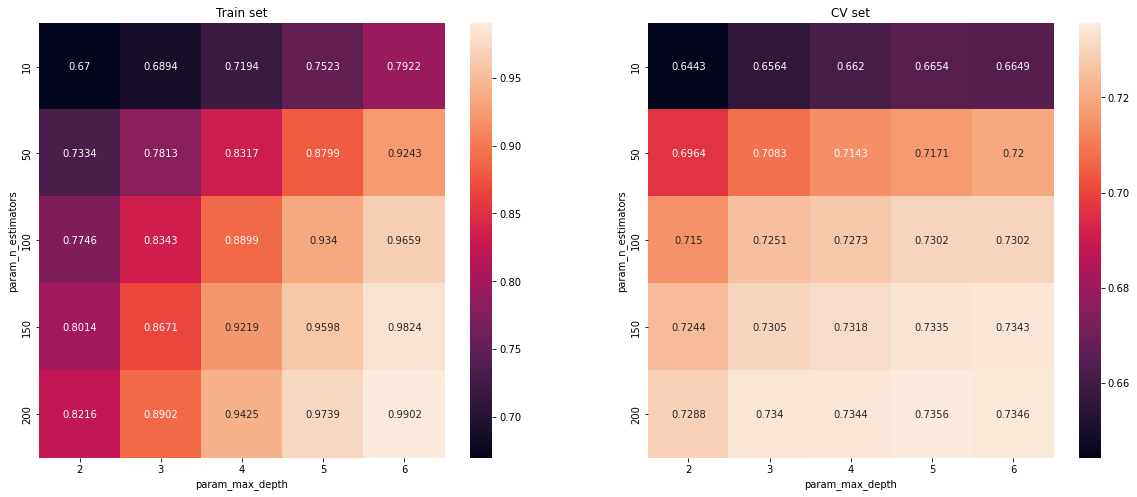

In [ ]:
scores = pandas.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
sns.heatmap(scores.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(scores.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])

ax[0].set_title('Train set')
ax[1].set_title('CV set')
plt.show()

In [ ]:
print('Best estimator: ' + str(clf.best_estimator_))
print('Train score: ' + str(clf.score(X_train_1, y_train)))
print('Test score: ' + str(clf.score(X_test_1, y_test)))

Best estimator: XGBClassifier(class_weight='balanced', max_depth=5, n_estimators=200, n_jobs=-1)
Train score: 0.951635535710622
Test score: 0.7556244932413205


In [ ]:
xgb_best = XGBClassifier(class_weight = 'balanced', n_jobs = -1)
params = {'n_estimators':[200], 'max_depth': [5]}

clf_best = GridSearchCV(xgb_best, params, cv = 3, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf_best.fit(X_train_1, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(class_weight='balanced', n_jobs=-1),
             n_jobs=-1, param_grid={'max_depth': [5], 'n_estimators': [200]},
             return_train_score=True, scoring='roc_auc')

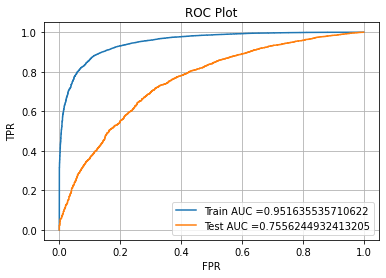

In [ ]:
y_train_pred_1 = clf_best.predict_proba(X_train_1)[:, 1]
y_test_pred_1 = clf_best.predict_proba(X_test_1)[:, 1]

train_fpr_1, train_tpr_1, train_threshold_1 = roc_curve(y_train, y_train_pred_1)
test_fpr_1, test_tpr_1, test_threshold_1 = roc_curve(y_test, y_test_pred_1)

auc_1 = auc(test_fpr_1, test_tpr_1)

plt.plot(train_fpr_1, train_tpr_1, label="Train AUC ="+str(auc(train_fpr_1, train_tpr_1)))
plt.plot(test_fpr_1, test_tpr_1, label="Test AUC ="+str(auc(test_fpr_1, test_tpr_1)))
plt.legend(prop = {'size': 10})
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Plot")
plt.grid()
plt.show()

In [ ]:
print(clf_best.best_estimator_)

XGBClassifier(class_weight='balanced', max_depth=5, n_estimators=200, n_jobs=-1)


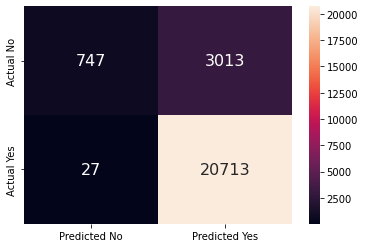

In [ ]:
y_predicted_class = clf_best.predict(X_train_1)
train_cm = pandas.DataFrame(confusion_matrix(y_train, y_predicted_class), range(2), range(2))
train_cm.columns = ['Predicted No', 'Predicted Yes']
train_cm.index = ['Actual No', 'Actual Yes']
sns.heatmap(train_cm, annot = True, annot_kws = {'size': 16}, fmt = 'g')
plt.show()

XGBoost for response coded categorical features, numerical features and TF-IDF W2V essays

In [ ]:
xgb_1 = XGBClassifier(class_weight = 'balanced', n_jobs = -1)
params = {'n_estimators':[10, 50, 100, 150, 200], 'max_depth': [2, 3, 4, 5, 6]}

clf_1 = GridSearchCV(xgb_1, params, cv = 3, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf_1.fit(X_train_2, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(class_weight='balanced', n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             return_train_score=True, scoring='roc_auc')

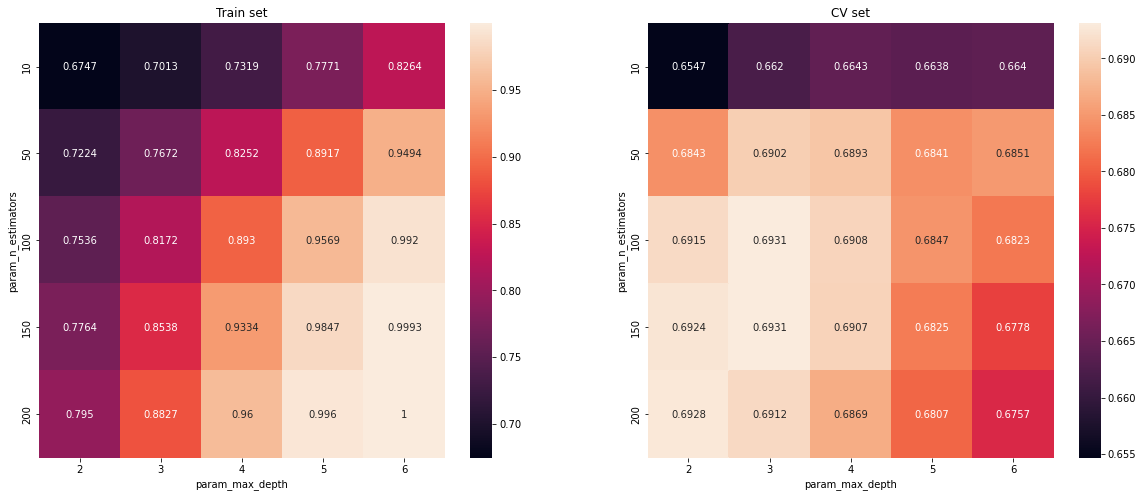

In [ ]:
scores_1 = pandas.DataFrame(clf_1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
sns.heatmap(scores_1.mean_train_score, annot = True, fmt = '.4g', ax = ax[0])
sns.heatmap(scores_1.mean_test_score, annot = True, fmt = '.4g', ax = ax[1])

ax[0].set_title('Train set')
ax[1].set_title('CV set')
plt.show()

In [ ]:
print('Best estimator: ' + str(clf_1.best_estimator_))
print('Train score: ' + str(clf_1.score(X_train_2, y_train)))
print('Test score: ' + str(clf_1.score(X_test_2, y_test)))

Best estimator: XGBClassifier(class_weight='balanced', n_estimators=150, n_jobs=-1)
Train score: 0.820397737181723
Test score: 0.6930464346849295


In [ ]:
xgb_best_1 = XGBClassifier(class_weight = 'balanced', n_jobs = -1)
params = {'n_estimators':[150], 'max_depth': [3]}

clf_best_1 = GridSearchCV(xgb_best_1, params, cv = 3, scoring = 'roc_auc', n_jobs = -1, return_train_score = True)
clf_best_1.fit(X_train_2, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(class_weight='balanced', n_jobs=-1),
             n_jobs=-1, param_grid={'max_depth': [3], 'n_estimators': [150]},
             return_train_score=True, scoring='roc_auc')

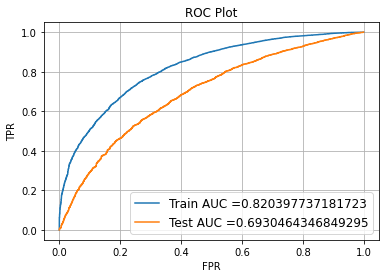

In [ ]:
y_train_pred_2 = clf_best_1.predict_proba(X_train_2)[:, 1]
y_test_pred_2 = clf_best_1.predict_proba(X_test_2)[:, 1]

train_fpr_2, train_tpr_2, train_threshold_2 = roc_curve(y_train, y_train_pred_2)
test_fpr_2, test_tpr_2, test_threshold_2 = roc_curve(y_test, y_test_pred_2)

auc_2 = auc(test_fpr_2, test_tpr_2)

plt.plot(train_fpr_2, train_tpr_2, label="Train AUC ="+str(auc(train_fpr_2, train_tpr_2)))
plt.plot(test_fpr_2, test_tpr_2, label="Test AUC ="+str(auc(test_fpr_2, test_tpr_2)))
plt.legend(prop = {'size': 12})
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Plot")
plt.grid()
plt.show()

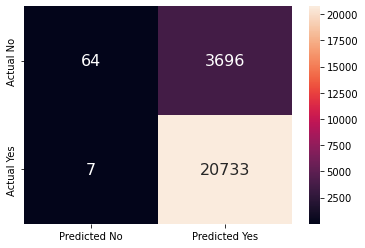

In [ ]:
y_predicted_class = clf_best_1.predict(X_train_2)
train_cm = pandas.DataFrame(confusion_matrix(y_train, y_predicted_class), range(2), range(2))
train_cm.columns = ['Predicted No', 'Predicted Yes']
train_cm.index = ['Actual No', 'Actual Yes']
sns.heatmap(train_cm, annot = True, annot_kws = {'size': 16}, fmt = 'g')
plt.show()

<h1>Summary</h1>


In [ ]:
grid = PrettyTable(['Vectorization', 'Model', 'n_estimators', 'max depth', 'AUC'])
grid.add_row(['TF-IDF', 'XGBoost', clf_best.best_estimator_.max_depth, clf_best.best_estimator_.n_estimators, auc_1])
grid.add_row(['TF-IDF W2V', 'XGBoost', clf_best_1.best_estimator_.max_depth, clf_best_1.best_estimator_.n_estimators, auc_2])
print(grid)

+---------------+---------+--------------+-----------+--------------------+
| Vectorization |  Model  | n_estimators | max depth |        AUC         |
+---------------+---------+--------------+-----------+--------------------+
|     TF-IDF    | XGBoost |      5       |    200    | 0.7556244932413205 |
|   TF-IDF W2V  | XGBoost |      3       |    150    | 0.6930464346849295 |
+---------------+---------+--------------+-----------+--------------------+
